<a href="https://colab.research.google.com/github/saulolvieira/saulo-portfolio/blob/main/predict_customer_buying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install sidetable

In [ ]:
# importando bibliotecas
# Data acsses
from google.colab import drive

# Data manipulation and treatment
import plotly.io                as pio
import pandas                   as pd
import sidetable                as stb
import matplotlib.pyplot        as plt
import numpy                    as np
import seaborn                  as sns
import plotly.express           as px
import plotly.graph_objects     as go
import pickle                   as pk

from plotly.subplots            import make_subplots

plt.style.use('ggplot')

In [ ]:
# Autenticação
drive.mount('/content/drive')

# Importando arquivo para dataframe
file_path = '/content/drive/MyDrive/Business & Professional/Ciência de Dados/British Airways - Case/Predict Customer Behavior/customer_booking.xlsx'
df = pd.read_excel(file_path)

# 1. Análise exploratória

In [ ]:
df1 = df.copy()
df1.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   num_passengers         50000 non-null  int64 
 1   sales_channel          50000 non-null  object
 2   trip_type              50000 non-null  object
 3   purchase_lead          50000 non-null  int64 
 4   length_of_stay         50000 non-null  int64 
 5   flight_hour            50000 non-null  int64 
 6   flight_day             50000 non-null  object
 7   route                  50000 non-null  object
 8   booking_origin         50000 non-null  object
 9   wants_extra_baggage    50000 non-null  int64 
 10  wants_preferred_seat   50000 non-null  int64 
 11  wants_in_flight_meals  50000 non-null  int64 
 12  flight_duration        50000 non-null  object
 13  booking_complete       50000 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 5.3+ MB


O dataset está completo, não tem necessidade de preencher valores faltantes.

## 1.1 Tipagem de dados

In [ ]:
df1.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete'],
      dtype='object')

In [ ]:
# Tratamento para variável 'flight_duration', retirando valores inconsistentes e preenchendo dados como duração 0 com média

df1['flight_duration'] = df1['flight_duration'].astype(str)
df1['flight_duration'] = df1['flight_duration'].str.replace('2023-07-05 00:00:00', '0')
df1['flight_duration'] = df1['flight_duration'].str.replace('2023-05-09 00:00:00', '0')
df1['flight_duration'] = df1['flight_duration'].astype(float)
df1['flight_duration'] = np.where(df1['flight_duration'] == 0, df1['flight_duration'].mean(), df1['flight_duration'])

# Arredondar os tempos de duração dos voos para melhor compreensão dos dados
df1['flight_duration'] = df1['flight_duration'].round()

## 1.2 Análise descritiva

In [ ]:
# Selecionando variáveis numéricas
var_num = df1[['num_passengers','purchase_lead', 'length_of_stay','flight_hour', 'flight_duration']]

In [ ]:
# Tendencia Central - Media, mediana
# Disperção - std, min, max, range, skew, kurtosis
num_statistics = pd.DataFrame({'min': var_num.min(),
                               'max': var_num.max(),
                               'media': var_num.mean(),
                               'mediana': var_num.median(),
                               'desvio_padrao': var_num.std(),
                               'amplitude': var_num.max() - var_num.min(),
                               'skewness' : var_num.skew(),
                               'curtose' : var_num.kurtosis()})
num_statistics

,min,max,media,mediana,desvio_padrao,amplitude,skewness,curtose
num_passengers,1.0,9.0,1.59124,1.0,1.020165,8.0,2.690908,10.062131
purchase_lead,0.0,867.0,84.94048,51.0,90.451378,867.0,1.653035,2.486702
length_of_stay,0.0,778.0,23.04456,17.0,33.887670,778.0,5.274743,48.810238
flight_hour,0.0,23.0,9.06634,9.0,5.412660,23.0,0.396623,-0.302438
flight_duration,5.0,9.0,7.50920,8.0,1.515085,4.0,-0.357546,-1.410092


In [ ]:
# Crie uma figura subplot com o número de linhas e colunas adequado ao seu conjunto de dados
fig = make_subplots(rows=2, cols=3)

# Defina as variáveis que serão exibidas nos histogramas
vars = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']

# Loop através das variáveis e adicione os histogramas às subplots correspondentes
for i, var in enumerate(vars):
    row = i // 3 + 1  # Determine o número da linha para adicionar o histograma
    col = i % 3 + 1   # Determine o número da coluna para adicionar o histograma

    # Crie o histograma para a variável atual
    hist = go.Histogram(x=df1[var], name=var)

    # Adicione o histograma à subplot correspondente
    fig.add_trace(hist, row=row, col=col)

# Atualize o layout para adicionar rótulos aos eixos e ajustar a altura das subplots
fig.update_layout(
    title="Histogramas das Variáveis Numéricas",
    height=600,
    width=1000
)

# Exiba a figura com as subplots
fig.show()

Necessário avaliar como tratar as seguintes variáveis:


*   length_of_stay: tem uma distribuição com muitos extremos, necessário identificar outliers e o que fazer com eles
*   purchase_lead: distribuição concentrada em um lado da curva normal, podemos avaliar aplicar log ou e também identificar se temos outliers



In [ ]:
def identify_outliers(df, column):

    # Calcular os limites superior e inferior usando o método IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Identificar os outliers
    outliers = df[(df[column] < limite_inferior) | (df[column] > limite_superior)]

    # Contar a quantidade de outliers
    quantidade_outliers = outliers.shape[0]

    # Calcular a porcentagem em relação ao total
    porcentagem_outliers = (quantidade_outliers / df.shape[0]) * 100

    # Exibir o resultado
    print(f"A quantidade de outliers na coluna '{column}' é: {quantidade_outliers}")
    print(f"O valor mais alto antes de considerar outlier é: {limite_superior:.2f}")
    print(f"A porcentagem de outliers em relação ao total é: {porcentagem_outliers:.2f}%")


In [ ]:
identify_outliers(df1, 'length_of_stay')

A quantidade de outliers na coluna 'length_of_stay' é: 3807
O valor mais alto antes de considerar outlier é: 62.50
A porcentagem de outliers em relação ao total é: 7.61%


In [ ]:
identify_outliers(df1, 'purchase_lead')

A quantidade de outliers na coluna 'purchase_lead' é: 3456
O valor mais alto antes de considerar outlier é: 256.00
A porcentagem de outliers em relação ao total é: 6.91%


In [ ]:
def apply_log_scale(df, column):
    variavel = df[column]
    variavel_sem_zeros = variavel + 1e-10  # Adiciona um valor pequeno para evitar zeros
    variavel_log = np.log(variavel_sem_zeros)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Histograma da variável original
    ax[0].hist(variavel, bins=30)
    ax[0].set_title('Variável Original')

    # Histograma da variável com escala logarítmica
    ax[1].hist(variavel_log, bins=30)
    ax[1].set_title('Variável com Escala Logarítmica')

    plt.show()

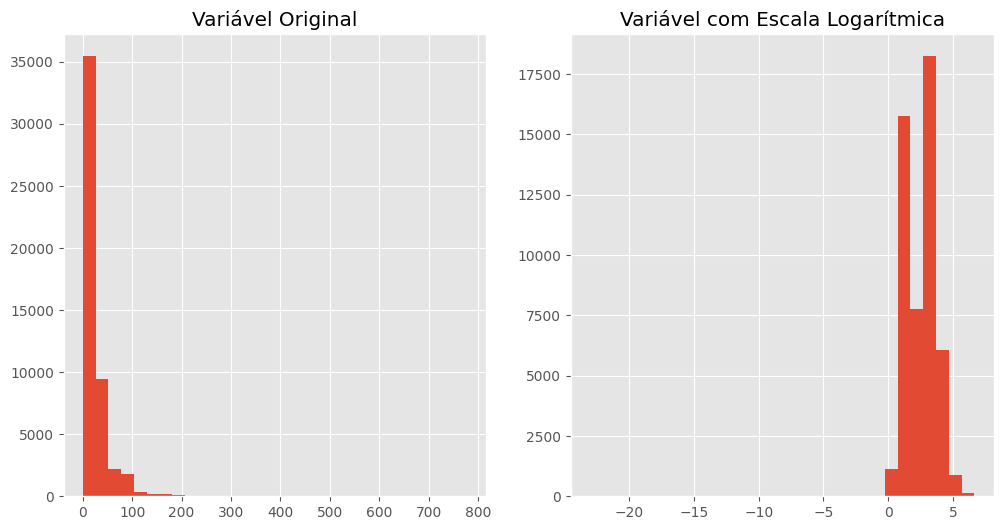

In [ ]:
apply_log_scale(df1, 'length_of_stay')

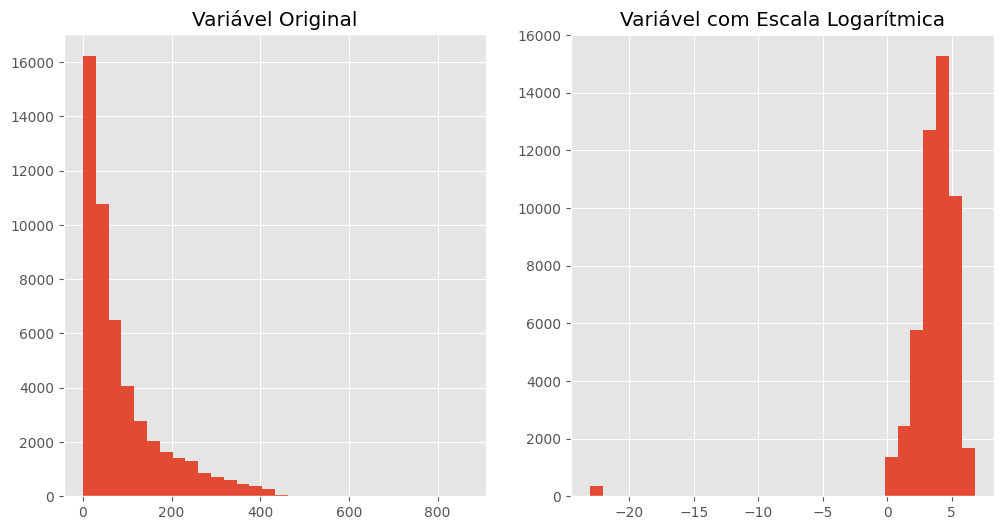

In [ ]:
apply_log_scale(df1, 'purchase_lead')

## 1.4 Variáveis categóricas

In [ ]:
atributos_categoricos.columns

Index(['sales_channel', 'trip_type', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'booking_complete'],
      dtype='object')

In [ ]:
# Contar quantos valores únicos tem por cada variável
atributos_categoricos.nunique()

sales_channel              2
trip_type                  3
flight_hour               24
flight_day                 7
route                    799
booking_origin           104
wants_extra_baggage        2
wants_preferred_seat       2
wants_in_flight_meals      2
booking_complete           2
dtype: int64

Para as variáveis rota e origem da reserva existem muitos valores únicos, deverão ser pensados estratégias específicas para tratar essas duas colunas em particular

In [ ]:
# Filtrando o dataframe para buscar apenas colunas categóricas com poucos valores únicos
df_cat_freq = atributos_categoricos.drop(columns = ['flight_hour', 'booking_complete', 'route', 'booking_origin'])

In [ ]:
# Define o número de colunas do dashboard
num_cols = 4

# Calcula o número de linhas necessárias
num_rows = len(df_cat_freq.columns) // num_cols + (len(df_cat_freq.columns) % num_cols > 0)

fig = make_subplots(rows= num_rows, cols= num_cols)

for i, column in enumerate(df_cat_freq.columns):
    row = i // num_cols + 1
    col = i % num_cols + 1

    fig.add_trace(go.Histogram(x=df_cat_freq[column], name = column), row= row, col=col)

# Atualiza o layout do dashboard
fig.update_layout(height=300*num_rows, width=1450, title_text="Distribuição das Variáveis Categóricas", bargap=0.4, title = dict(x=0.5))

# Exibe o dashboard
fig.show()

Em geral as variáveis categóricas com poucas classes são bem distribuídas. Salvo apenas duas exceções para canal de compra e o tipo de viagem que nãoe stão muito bem balanceadas.

Ficaram duas variáveis com muitos valores únicos diferentes pendentes para análise. Visto que estamos tratando de rota e origem da compra, talvez seja interessante agrupar os dados de acordo com as regiões por exemplo

In [ ]:
# Relação entre tipo de viagem e compra ou não da passagem

df_count = df.groupby(["trip_type", "booking_complete"]).size().reset_index(name="Count")
fig = px.bar(df_count, x="trip_type", y="Count", color="booking_complete", barmode="group")
fig.show()

In [ ]:
# Relação entre tipo de viagem e compra ou não da passagem
#cria dataset auxiliar
df_count_2 = df.groupby(["sales_channel", "booking_complete"]).size().reset_index(name="Count")

fig = px.bar(df_count_2, x="sales_channel", y="Count", color="booking_complete", barmode="group")
fig.show()

In [ ]:
df1['booking_origin'].value_counts().reset_index()

,index,booking_origin
0,Australia,17872
1,Malaysia,7174
2,South Korea,4559
3,Japan,3885
4,China,3387
...,...,...
99,Panama,1
100,Tonga,1
101,Tanzania,1
102,Bulgaria,1


In [ ]:
# Variável alvo
df_alvo = atributos_categoricos.booking_complete.value_counts(normalize= True).reset_index()

fig = px.bar(df_alvo, x = "index", y = "booking_complete", text_auto = True)
fig.show()

Como podemos observar tempos um dataset desbalanceado. Para problemas de classificação isso é um fator importante que deverá ser levado em conta na experimentação